# GA4GH Data Access Example

For this example, metadata have been loaded into a test data registry so they can be accessed using GA4GH methods. `python gdc_dos.py`

## Import the client and models

This will import a Python client and models for accessing data as defined in the schemas.

In [3]:
from ga4gh.dos.client import Client
local_client = Client('http://localhost:8080/ga4gh/dos/v1')
client = local_client.client
models = local_client.models

## Listing Data Objects

To list the existing Data Objects, we send a ListDataObjectsRequest to the `ListDataObjects` method!

In [4]:
ListDataObjectsRequest = models.get_model('ListDataObjectsRequest')
list_request = client.ListDataObjects(body=ListDataObjectsRequest(page_size=10000000))
list_response = list_request.result()
print("Number of Data Objects: {} ".format(len(list_response.data_objects)))

Number of Data Objects: 2882 


These Data Object messages are for testing purposes only but should contain enough to retrieve their contents from GDC servers.

In [5]:
data_objects = list_response.data_objects
data_object = data_objects[11]
print('url: {}, file_size (B): {}'.format(data_object.urls[0].url, data_object.size))

url: https://api.gdc.cancer.gov/data/72fa5f40-1ade-4088-8390-b8bc970d12f1, file_size (B): 516230


## Filter Public Data

We want to use this service to eventually download data, but first we must find data we have access to.

In [6]:
public_data_objects = filter(
    lambda x: x['urls'][0]['system_metadata']['access'] == 'open', 
    data_objects)
print('Number of public Data Objects: {}'.format(len(public_data_objects)))

public_data_object = public_data_objects[0]

Number of public Data Objects: 1341


## Download a file

We can then download this file and name it.

In [7]:
import requests

# https://stackoverflow.com/questions/16694907/how-to-download-large-file-in-python-with-requests-py
def download_file(url, filename):
    # NOTE the stream=True parameter
    r = requests.get(url, stream=True)
    with open(filename, 'wb') as f:
        for chunk in r.iter_content(chunk_size=1024): 
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)
                #f.flush() commented by recommendation from J.F.Sebastian
    return filename

In [8]:
download_file(public_data_object.urls[0].url, data_object.name)

u'944ee313-bcf5-480c-9ce8-05821746fb34.FPKM-UQ.txt.gz'

## Verify the checksum

Data Object messages contain checksums of the underlying files. We can validate it here.

In [9]:
print(public_data_object.checksums)

[Checksum(checksum=u'40d83610bbae6dcf8973590c226d4d04', type=u'md5')]


In [10]:
given_checksum = public_data_object.checksums[0].checksum

# https://stackoverflow.com/questions/3431825/generating-an-md5-checksum-of-a-file
import hashlib
def md5(fname):
    hash_md5 = hashlib.md5()
    with open(fname, "rb") as f:
        for chunk in iter(lambda: f.read(4096), b""):
            hash_md5.update(chunk)
    return hash_md5.hexdigest()

print(md5(data_object.name))
print(given_checksum)
print(given_checksum == md5(data_object.name))

40d83610bbae6dcf8973590c226d4d04
40d83610bbae6dcf8973590c226d4d04
True


## Visualizing the contents of the registry

Here, we look at the file sizes of the contents of the registry. This is a histogram where each bin is a count of the number of files with a size in that range. We plot with a log axis because of the number of very small files dominates a linear scale.

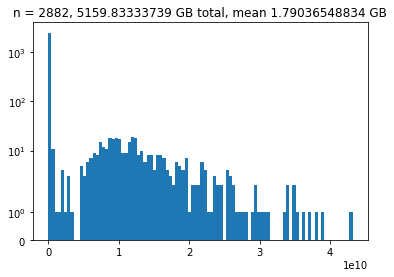

In [11]:
import matplotlib.pyplot as plt
file_sizes = [float(x.size) for x in data_objects]
plt.hist(file_sizes, bins=96)
plt.title("n = {}, {} GB total, mean {} GB".format(len(file_sizes), str(sum(file_sizes) / 1000000000.0), (sum(file_sizes) / len(file_sizes)) / 1000000000.0 ))
plt.yscale('symlog')
plt.show()

Observe that most of the non-tiny files are around 2GB and a few files are very large.

## Make a Data Bundle of some Data Objects

We can now organize some of the Data Objects into a bundle so we can share them together. 

For example, a few publicly available items. First, we have to gather the list of data objects and compute their concatenated hash.

### Calculate the hash for our Objects

In [12]:
public_data_object_ids = [x.id for x in public_data_objects]
print(public_data_object_ids[0])
hashes = [x.checksums[0].checksum for x in public_data_objects]
print(hashes[0])
bundle_md5 = hashlib.md5()
bundle_md5.update(''.join(hashes[0:10]))
bundle_digest = bundle_md5.hexdigest()
print(bundle_digest)

238dc9ee-c1de-4803-8e95-bc21f3a7e806
40d83610bbae6dcf8973590c226d4d04
abf6bc6f18bee84a17c9ece681de5f93


### Create a new Data Bundle

In [14]:
CreateDataBundleRequest = models.get_model('CreateDataBundleRequest')
DataBundle = models.get_model('DataBundle')
Checksum = models.get_model('Checksum')
my_bundle = DataBundle(
    name="My Bundle",
    checksums=[Checksum(checksum=bundle_digest, type='md5')],
    data_object_ids=public_data_object_ids[0:10],
    aliases=["bundle-alias", "access:public"])
create_request = CreateDataBundleRequest(data_bundle=my_bundle)
create_response = client.CreateDataBundle(body=create_request).result()
print(create_response.data_bundle_id)

c4dbd853-a057-4910-b2b1-d16211fd4031


Let's now verify the Data Bundle appears as expected:

In [15]:
get_bundle_response = client.GetDataBundle(data_bundle_id=create_response.data_bundle_id).result()
print(get_bundle_response.data_bundle.data_object_ids)

[u'238dc9ee-c1de-4803-8e95-bc21f3a7e806', u'10e4ee41-ed07-488f-b024-dc47103ebcdc', u'9035cbd8-439c-49d5-9c28-f6620a0268f9', u'0e9e4a38-d6c5-4c6e-8044-93d9c2bdc686', u'c3c5adb2-d5ae-4d89-9c38-fe9178ce5665', u'2e9b7043-e5c4-4168-b4e5-13a929f48846', u'4d67906b-6f98-4aa3-b095-15a53b7a5a5f', u'b0002ca4-d762-40c1-b4e0-d40e2988f6f0', u'dc0dece5-71a1-4920-a779-cd256d2f47b1', u'88b51e89-0888-40b3-bef8-4725d1857de2']
